In [543]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as am
import matplotlib.colors as mcolors
from scipy.optimize import minimize
from scipy.stats import linregress

In [544]:
filenames = [
    'PCNA_23-24C_12072022-01.csv', 
    'PCNA_from 1cell_11042023-01_AcquisitionBlock1_pt1_Detailed.csv', 
    'PCNA_06062022-01-2_AcquisitionBlock1_pt1.csv',
    'PCNA_06062022-01-2_AcquisitionBlock2_pt2.csv',
    'wee1 inhibitor in PCNA_2602023-01_AcquisitionBlock1_pt1_Detailed.csv',
    'wee1 inhibitor in PCNA_2602023-01_AcquisitionBlock2_pt2_Detailed.csv'
]
frame_to_times = [
    18.87, 38.97, 52, 52, 39.86, 39.86
]
headers = [1, 2, 2, 2, 2, 2]


round_frames = [
    [  0,  86, 186, 281, 375, 469, 562],
    [  0,  48,  95, 140, 183, 227, 269, 312],
    [  0,  24,  59,  93, 125, 157, 189, 222],
    [  0,  18,  52,  85, 115, 146, 178, 210, 246],
    [  0,  24,  59,  94, 128, 163, 198, 236, 279],
    [  0,  24,  59,  95, 129, 164, 200, 237, 281]
]

n = 5
filename = filenames[n]
f2t = frame_to_times[n]
f_start = np.array(round_frames[n])

df = pd.read_csv('Data/'+filename, header=headers[n])

In [545]:
X = np.array(df['Position X'])
Y = np.array(df['Position Y'])
Z = np.array(df['Position Z'])
T = np.array(df['Time'])
S = np.array(df['Surface or deep'])
TrackID = np.array(df['TrackID'])

In [546]:
slices = [] 
for t in range(min(T), max(T)): 
    x = X[T==t]
    y = Y[T==t]
    z = Z[T==t]
    ids = TrackID[T==t]
    surface = (S[T==t] == 'Surface')
    c = len(ids)
    d = {'x': x, 'y': y, 'z': z, 'id': ids, 'sur':surface, 'count': c}
    slices.append(d)

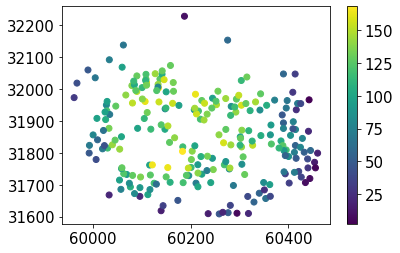

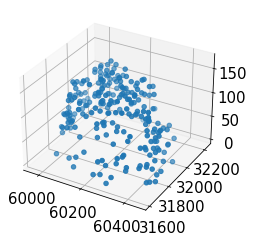

In [547]:
s = slices[-1] 
x = s['x']
y = s['y']
z = s['z']

plt.scatter(x, y, c=z)
plt.colorbar() 
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)
plt.show()

In [548]:
divisions = [] 
old_id = [] 
for s in slices: 
    ids = s['id']
    indices = np.in1d(ids, old_id, invert=True)
    x = s['x'][indices]
    y = s['y'][indices]
    z = s['z'][indices]
    sur = s['sur'][indices]
    c = sum(indices)
    d = {'x':x, 'y':y, 'z':z, 'sur': sur, 'count':c, 'ids': ids[indices]}
    divisions.append(d)
    old_id = ids 

In [549]:
# plt.rc('font', size=25)
# fig = plt.figure(figsize=(13, 10))

# # Plot the movie one snapshot at a time 
# ims = []
# for s in slices:
#     im = plt.scatter(s['x'], s['y'], c=s['id'])
#     ims.append([im])
# ani = am.ArtistAnimation(fig, ims, interval=100, blit=True,
#                                 repeat_delay=1000)
# mywriter = am.FFMpegWriter()
# ani.save("Data/movie.mp4", writer=mywriter)
# plt.close()

# # Set up figure plotting 
# plt.rc('font', size=25)
# fig = plt.figure(figsize=(13, 10))

# # Plot the movie one snapshot at a time 
# ims = []
# for d in divisions:
#     im = plt.scatter(d['x'], d['y'])
#     ims.append([im])
# ani = am.ArtistAnimation(fig, ims, interval=100, blit=True,
#                                 repeat_delay=1000)
# mywriter = am.FFMpegWriter()
# ani.save("Data/div.mp4", writer=mywriter)
# plt.close()

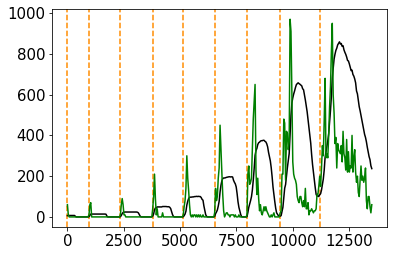

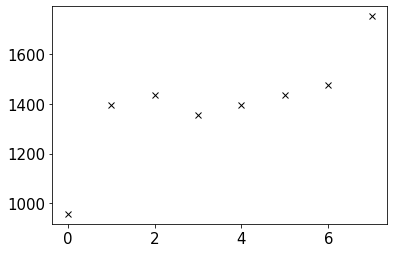

In [550]:
t_span = np.arange(len(slices))*f2t
total = np.array([s['count'] for s in slices])
divs = np.array([d['count'] for d in divisions])
total_diff = total[1:]-total[:-1]
a = (total_diff > 0).astype('int')
w = int(10*50/f2t)
a = np.convolve(a, np.ones(w), 'valid')/w
a = ((a > 0)).astype('int')


diff = a[1:]-a[:-1]
# this is used to calculate f_start
# f_start = np.argwhere((diff>0) & (divs[1+w:] > 0) )+1+w
# f_start = np.append(f_start, 0)
# f_start = np.sort(f_start)
# print(f_start)
f_cutoff = f_start[3] # before t_cutoff, all cells are surface cells 

for f in f_start: 
    plt.axvline(x=t_span[f], color='darkorange', linestyle='--')
plt.plot(t_span, total, 'k-')
plt.plot(t_span, divs*10, 'g-')
plt.show() 

plt.plot((f_start[1:]-f_start[:-1])*f2t, 'kx')
plt.show() 

In [551]:
index = 0
for (i, d) in enumerate(divisions):
    if i < f_cutoff:
        d['sur'] = [True]*len(d['x']) # all cells are surface cells below the cutoff point
    if index < len(f_start) and i >= f_start[index]: 
        index += 1 
    d['index'] = index-1

In [552]:
# First, collect surface data for all rounds 

track_index = -1 
sur_rounds = [] 
rounds = [] 
for (i, d) in enumerate(divisions): 
    index = d['index']
    if index > track_index and index < len(f_start): 
        rounds.append([])
        sur_rounds.append([])
        track_index = index
    
    if len(d['x'])>0:
        t_array = np.full(len(d['x']), i*f2t)
        rounds[index] += zip(d['x'], d['y'], d['z'], t_array) 
    
    if np.sum(d['sur']) > 0: # this excludes the last round, since the surface data has not been labelled 
        sur = d['sur']
        x = d['x'][sur]
        y = d['y'][sur]
        z = d['z'][sur]
        t_array = np.full(len(x), i)*f2t
        sur_rounds[index] += zip(x, y, z, t_array)   

for i in range(len(rounds)):
    sur_rounds[i] = np.array(sur_rounds[i])
    rounds[i] = np.array(rounds[i])

## Next, we will find the semi-major and semi-minor axes of the ellipse in the x-y plane to look at the geometry in 2D 

x0, y0, z0:  60218.05 31916.75 13.2735
a, b, theta:  [1.5299767  3.34518951 0.0380033 ]
R:  106.5636481957378
std of R:  8.54179032646609


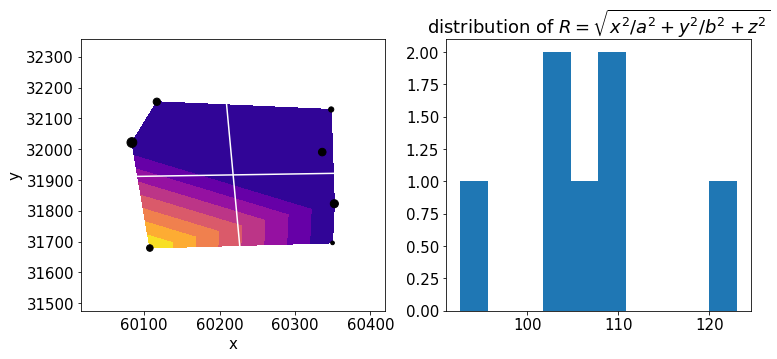

x0, y0, z0:  60221.25 31912.0 2.5
a, b, theta:  [1.92564549 2.62227973 0.06901822]
R:  119.0718419620882
std of R:  11.144065315863035


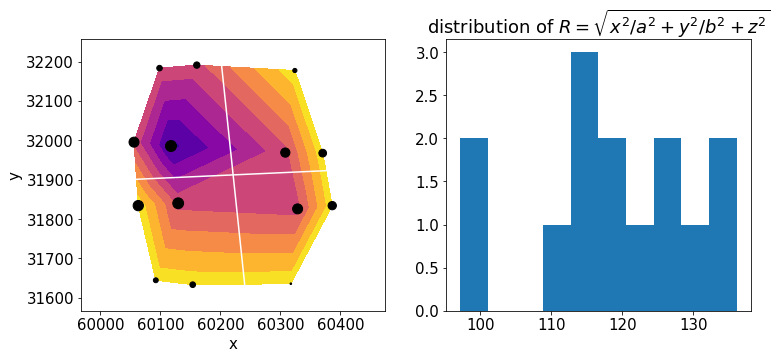

x0, y0, z0:  60217.850000000006 31905.3 2.5
a, b, theta:  [2.43701034 2.64251424 0.02998089]
R:  106.37812348331028
std of R:  11.253524810255596


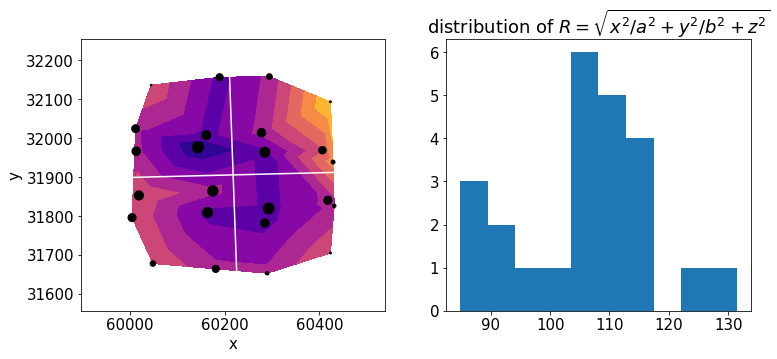

x0, y0, z0:  60221.35 31916.6 2.5
a, b, theta:  [1.95122415 2.3739364  0.16921323]
R:  130.0538091380861
std of R:  11.467848336797708


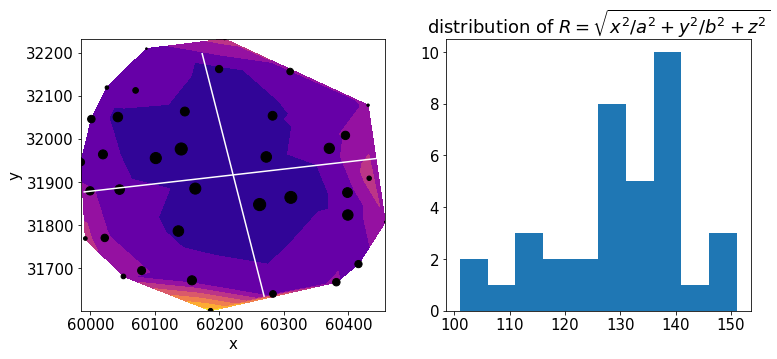

x0, y0, z0:  60204.9 31916.95 2.5
a, b, theta:  [1.7749906  2.17008601 0.        ]
R:  143.09237129511087
std of R:  12.144391137243064


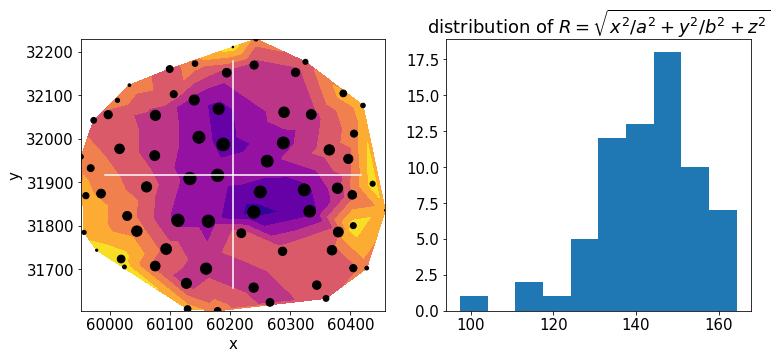

In [553]:
def f(a, r): 
    theta = a[-1]
    r1 = (np.cos(theta), np.sin(theta))
    r2 = (-np.sin(theta), np.cos(theta))
    return np.sqrt(np.dot(r[:, :2], r1)**2/a[0]**2 + np.dot(r[:, :2], r2)**2/a[1]**2+r[:, 2]**2)

plt.rc('font', size=15)
for r in sur_rounds: 
    if len(r) > 3: 
        x = r[:, 0]
        y = r[:, 1]
        z = r[:, 2]
        t = r[:, 3]

        x0 = (min(x)+max(x))/2
        y0 = (min(y)+max(y))/2
        z0 = min(z)
        r0 = np.array((x0, y0, z0))[np.newaxis, :]
        print('x0, y0, z0: ', x0, y0, z0)

        cost = lambda a: np.std(f(a, r[:, :3]-r0))
        res = minimize(cost, (1, 1, np.pi/5), bounds=[(0.1, None), (0.1, None), (0, np.pi)])
        R = np.mean(f(res.x, r[:, :3]-r0))
        print('a, b, theta: ', res.x)
        print('R: ', R)
        print('std of R: ', res.fun)

        theta = res.x[-1]
        a = res.x[0]*120
        b = res.x[1]*120
        x1 = [-a*np.cos(theta)+x0, a*np.cos(theta)+x0]
        y1 = [-a*np.sin(theta)+y0, a*np.sin(theta)+y0]
        x2 = [b*np.sin(theta)+x0, -b*np.sin(theta)+x0]
        y2 = [-b*np.cos(theta)+y0, b*np.cos(theta)+y0]

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].tricontourf(x, y, t, cmap='plasma')
        axes[0].scatter(x, y, s=z, c='k')
        axes[0].plot(x1, y1, x2, y2, color='white')
        axes[0].set_xlabel('x')
        axes[0].set_ylabel('y')

        axes[1].hist(f(res.x, r[:, :3]-r0))
        axes[1].set_title(r'distribution of $R = \sqrt{x^2/a^2+y^2/b^2+z^2}$')
        
        plt.show()

## By eye, the best fit params are close enough. So for simplicity, we use the params of the last round. 

In [554]:
def get_phi_theta(r, a, b, c, angle):
    z = r[:, -1]
    r1 = (np.cos(angle), np.sin(angle), 0)
    r2 = (-np.sin(angle), np.cos(angle), 0)
    vector = np.array((np.dot(r, r1), np.dot(r, r2), z)) # vector in the coordinate of the ellipse axes
    phi = np.arctan2(vector[1]/b, vector[0]/a)
    theta = np.arctan2(np.sqrt((vector[0]/a)**2+(vector[1]/b)**2), z/c)
    return phi, theta    

In [555]:
a, b, angle = res.x 
a, b, c = a*R, b*R, R

spherical_polar = [] 
for index in range(len(rounds)):
    r = rounds[index]
    r = r[:, :3] - r0 
    z = r[:, 2]
    
    d = np.sqrt(np.sum(r**2, axis=-1))
    phi, theta = get_phi_theta(r, a, b, c, angle)
    D =  np.array([a*np.cos(phi)*np.sin(theta), b*np.sin(phi)*np.sin(theta), c*np.cos(theta)])
    D = np.sqrt( D[0]**2 + D[1]**2 + D[2]**2)
    ratio = d/ D  # depth under the surface
    spherical_polar.append(np.stack([d, phi, theta, D]).T)

## Find the surface cells of the last round of division 

In [556]:
for index in range(len(rounds)):
    r = rounds[index]
    s = sur_rounds[index]
    if len(s) < 4: 
        A = spherical_polar[index]
        d = A[:, 0] 
        D = A[:, -1]
        ratio = d/D 
        sur_rounds[index] = r[ratio>0.8]

## Plot the depth ratio on a spherical polar plot

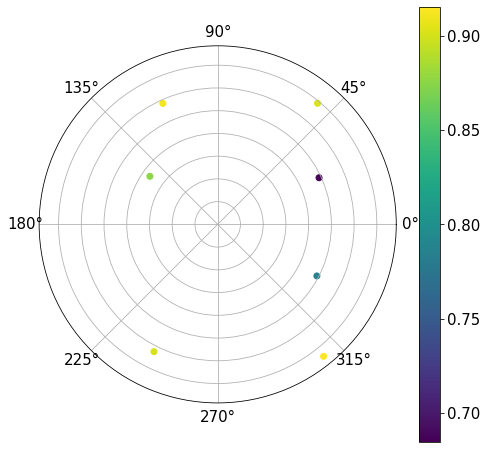

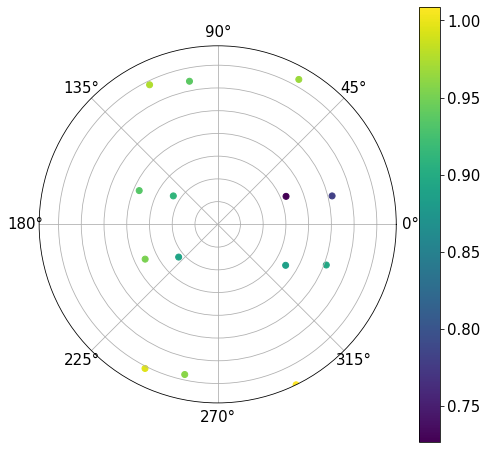

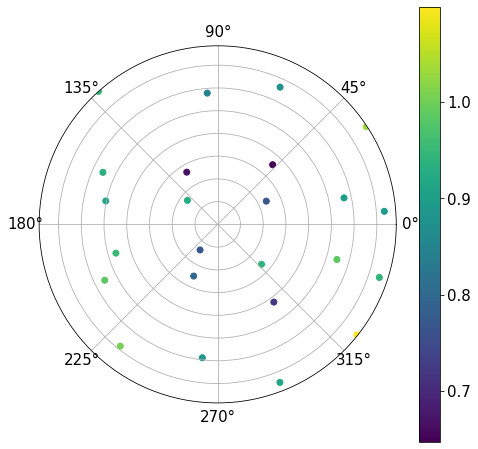

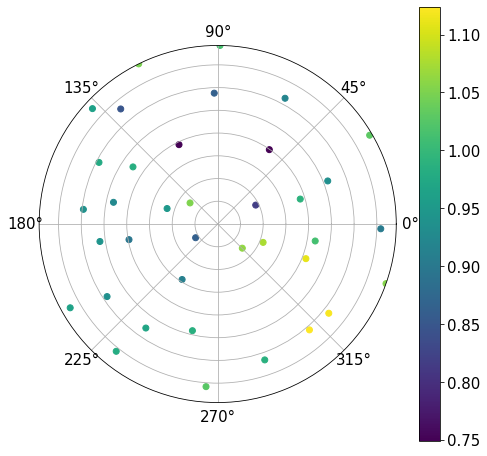

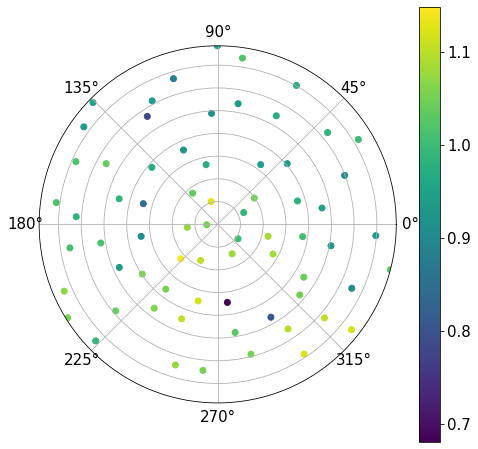

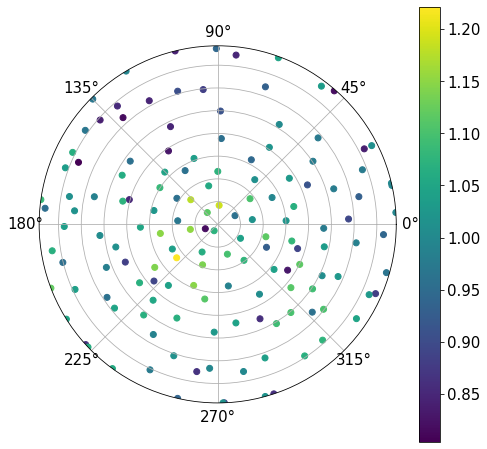

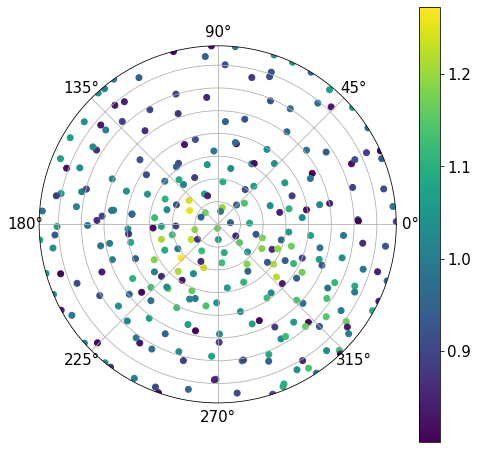

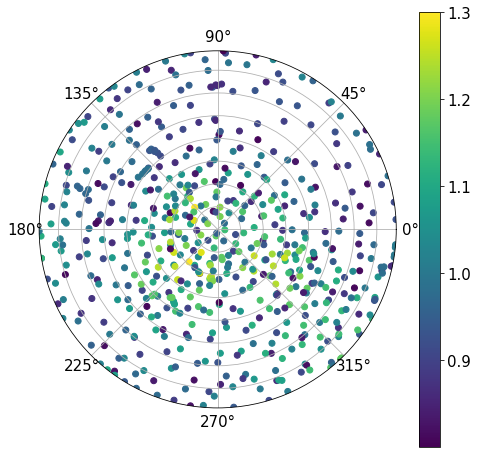

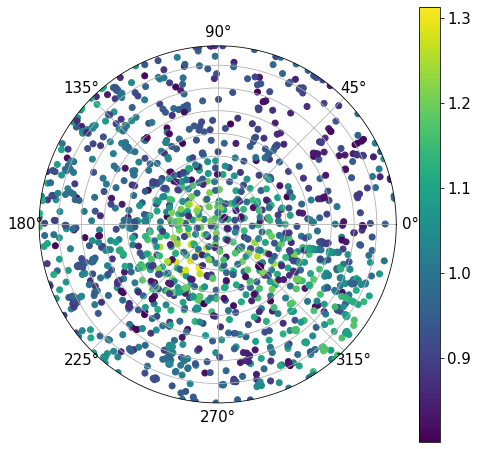

In [557]:
sur_spherical_polar = [] 
for index in range(len(sur_rounds)):
    r = sur_rounds[index]
    r = r[:, :3] - r0 
    z = r[:, 2]
    
    d = np.sqrt(np.sum(r**2, axis=-1))
    phi, theta = get_phi_theta(r, a, b, c, angle)
    D =  np.array([a*np.cos(phi)*np.sin(theta), b*np.sin(phi)*np.sin(theta), c*np.cos(theta)])
    D = np.sqrt( D[0]**2 + D[1]**2 + D[2]**2)
    ratio = d/ D  # depth under the surface
    sur_spherical_polar.append(np.stack([d, phi, theta, D]).T)
    
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
    im = ax.scatter(phi, theta, c=ratio)
    ax.set_ylim([0, np.pi/2])
    ax.set_yticklabels([])
    plt.colorbar(im)
    plt.show() 

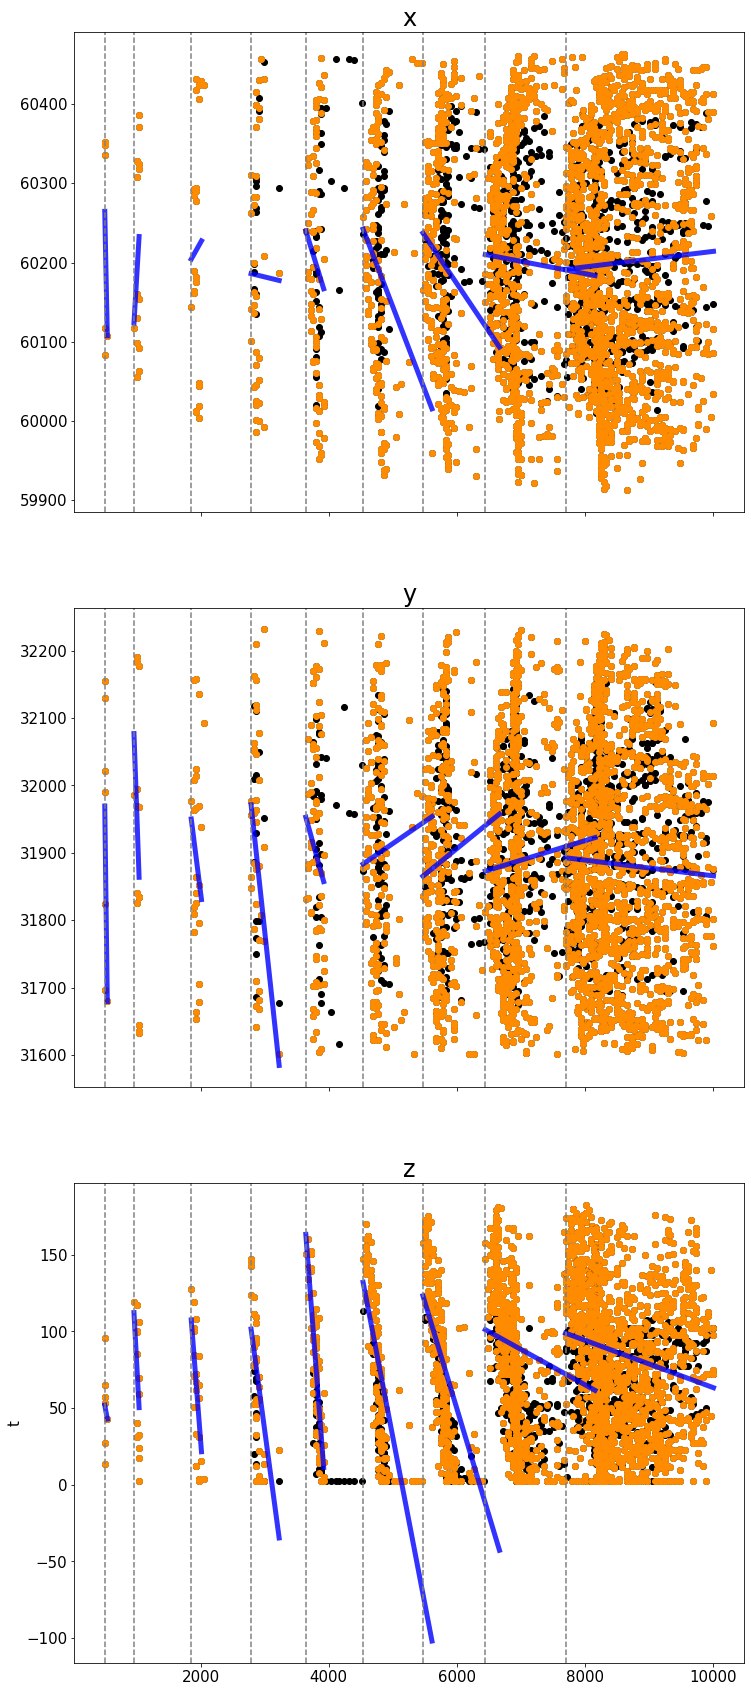

In [558]:
omega0 = 500 # subtrack off a constant frequency to see a bigger spread 

k = ['x', 'y', 'z']
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 30))
plt.rc('font', size=20)
for index in range(len(rounds)):
    r = rounds[index]
    s = sur_rounds[index]
    offset = (index-1)*omega0
    
    
    for i in range(3):
        axes[i].scatter(r[:, 3]-offset, r[:, i], color='k')
        t = s[:, 3]-offset
        axes[i].scatter(t, s[:, i], color='darkorange')
        z = s[:, 2]
        res = linregress(t[z>10], s[:, i][z>10])
        axes[i].plot(t[z>10], res.intercept + res.slope*t[z>10], color='blue', alpha=0.8, linewidth=5)
        axes[i].axvline(x=(f_start[index])*f2t-offset, color='grey', linestyle='--')
        axes[i].set_title(k[i])
axes[2].set_ylabel('t')
plt.savefig('Figures/{}_grad_fit_xyz.pdf'.format(filename))
plt.show() 

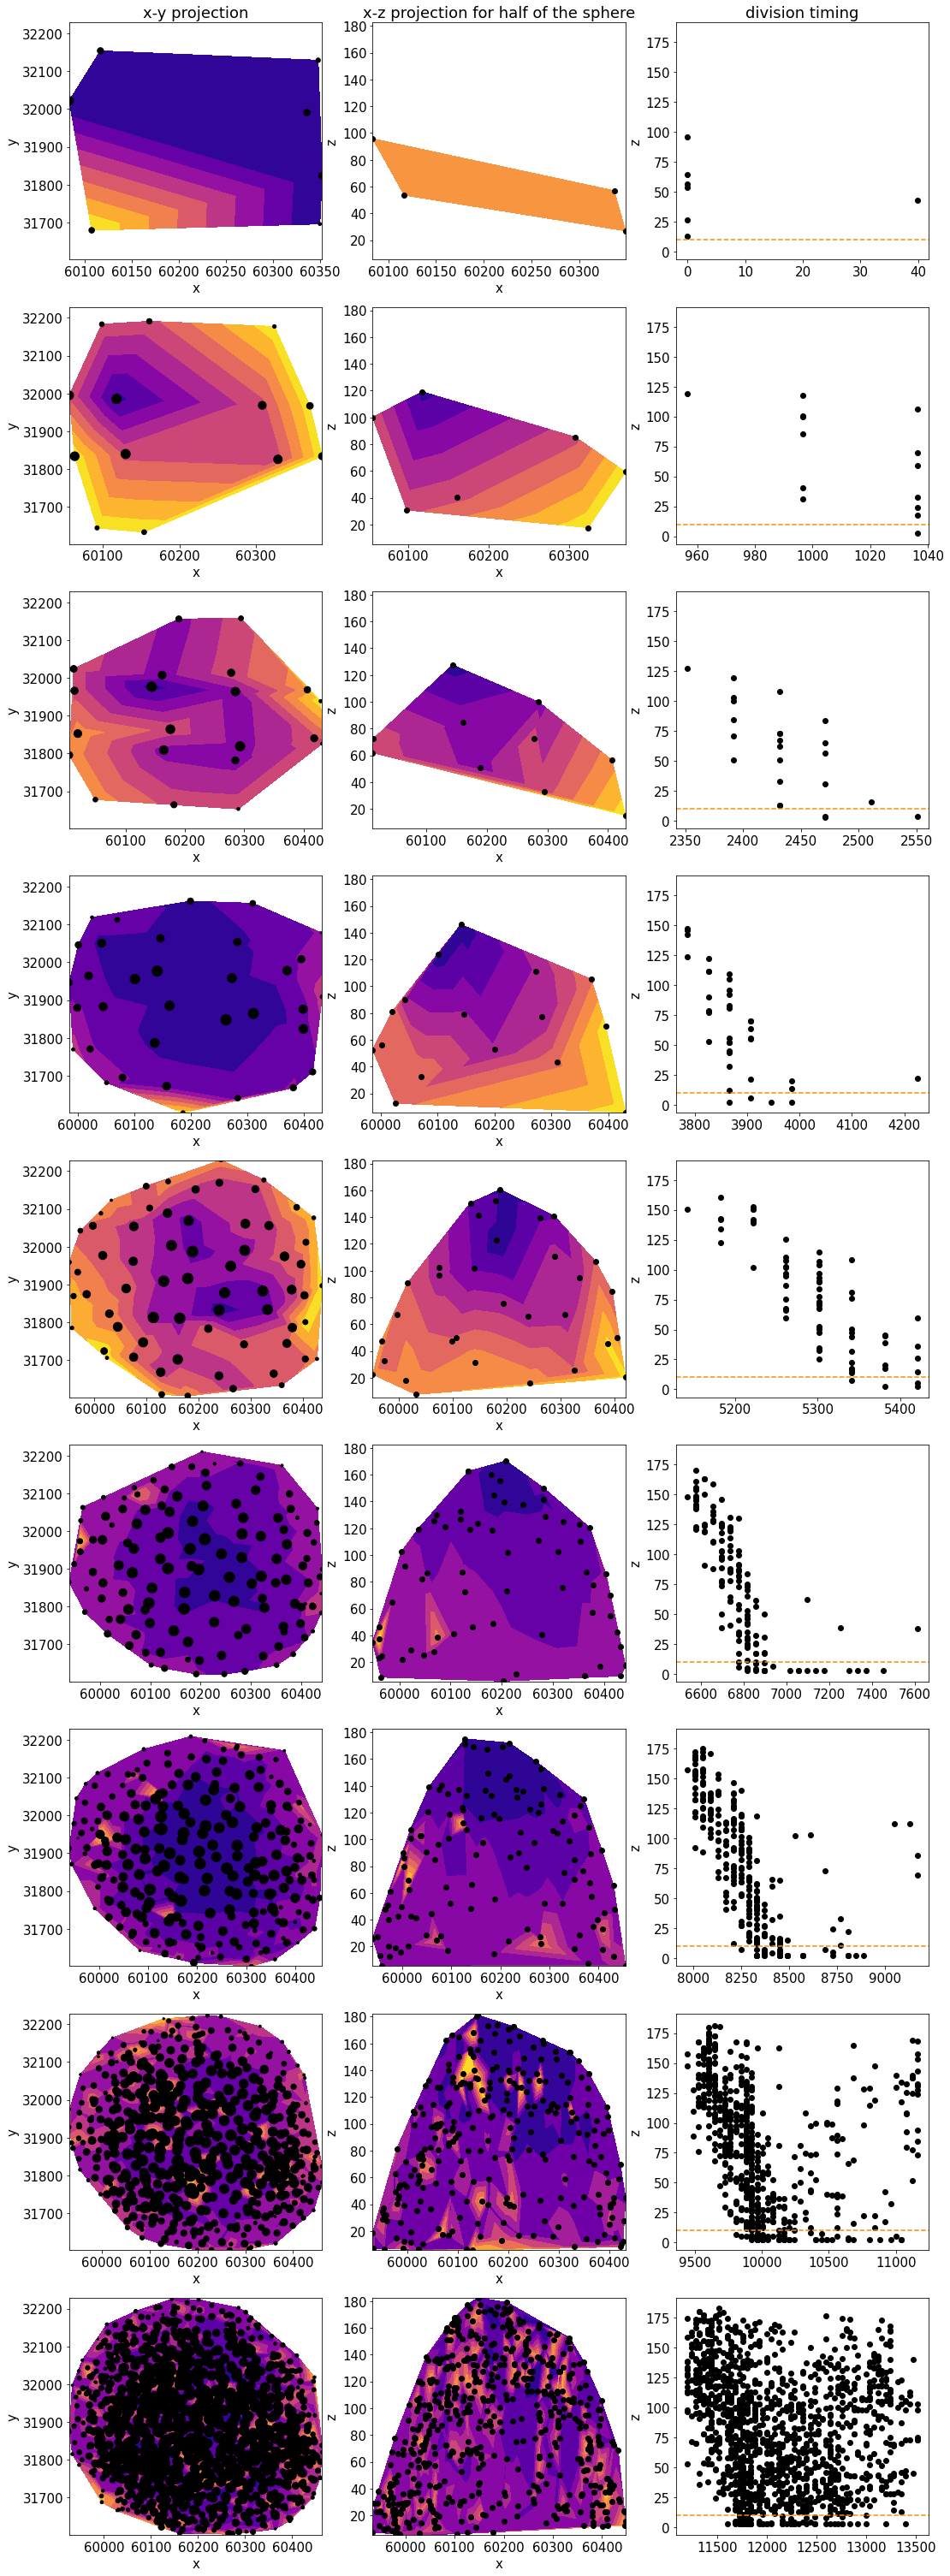

In [559]:
z_cutoff = 5
plt.rc('font', size=15)
fig, axes = plt.subplots(len(rounds), 3, sharey='col', figsize=(18, 6*len(rounds)))
for index in range(len(rounds)): 
    r = sur_rounds[index]
    x = r[:, 0]
    y = r[:, 1]
    z = r[:, 2]
    t = r[:, -1]
    m = (z > z_cutoff)
    axes[index, 0].tricontourf(x[m], y[m], t[m], cmap='plasma')
    axes[index, 0].scatter(x[m], y[m], s=z[m], c='k')
    axes[index, 0].set_xlabel('x')
    axes[index, 0].set_ylabel('y')
    
    y0 = np.mean(y)
    m = (y > y0) & m
    if np.sum(m) > 3: 
        axes[index, 1].tricontourf(x[m], z[m], t[m], cmap='plasma')
        axes[index, 1].scatter(x[m], z[m], c='k')
        axes[index, 1].set_xlabel('x')
        axes[index, 1].set_ylabel('z')
    
    axes[index, 2].scatter(t, z, c='black')
    axes[index, 2].axhline(y=10, linestyle='--', color='darkorange' )
    axes[index, 2].set_ylabel('z')

axes[0, 0].set_title('x-y projection')
axes[0, 1].set_title('x-z projection for half of the sphere')
axes[0, 2].set_title('division timing')
plt.savefig('Figures/{}_division_timing.pdf'.format(filename[:-4]))
plt.show()